In [8]:
! pip install -q -U langchain_core langchain-google-genai langgraph

In [9]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langgraph.graph import StateGraph,START,END
from typing_extensions import TypedDict
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage
from IPython.display import display,Image
from langgraph.graph.state import CompiledStateGraph

In [10]:
#Loading Environment Variables
load_dotenv()

# Storing api_key in the variable
api_key = os.getenv("GEMINI_API_KEY")

# Intializing Model
llm : ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=api_key)

In [15]:

class State (TypedDict):
    text:str
    classification:str
    entities:list[str]
    summary:str


def classification(state:State):
    """ Classify the text into one of the categories: News, Blog, Research, or Other"""
    
    prompt = PromptTemplate(input_variables=["text"],template="Classify the following text into one of the categories: News, Blog, Research, or Other and don't describe just give the name.\n\nText:{text}\n\nCategory:")
    
    message = HumanMessage(content=prompt.format(text=state["text"]))
    classification_result = llm.invoke([message]).content.strip()
    state["classification"] = classification_result
    return state

def entity_extraction_node(state:State):
    """Extract all the entities (Person, Organization, Location) from the text"""
    
    prompt = PromptTemplate(
        #Input Variable is a placeholder here you can pass anything here 
        input_variables=["text"],
        # template is somehow same as a prompt which we give the model
        template="Extract all the entities (Person, Organization, Location) from the following text. Provide the result as a comma-separated list.\n\nText:{text}\n\n")
    
    message = HumanMessage(content=prompt.format(text=state["text"]))
    
    entity_extraction_result = llm.invoke([message]).content.strip().split(",")
    state["entities"] = entity_extraction_result
    return state

def Summary(state:State):
    """ Summarize the text in one short sentence"""
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Summarize the following text in one short sentence.\n\nText:{text}\n\nSummary:")
    message = HumanMessage(content=prompt.format(text=state["text"]))
    summary_result = llm.invoke([message]).content.strip()
    state["summary"] = summary_result
    return state
    

In [16]:

workflow : StateGraph = StateGraph(State)

# Adding Nodes
workflow.add_node("Classification of text",classification)
workflow.add_node("Extraction of entities from text",entity_extraction_node)
workflow.add_node("Summarization of text",Summary)

# Connecting nodes through edges

workflow.set_entry_point("Classification of text")
workflow.add_edge("Classification of text","Extraction of entities from text")
workflow.add_edge("Extraction of entities from text","Summarization of text")
workflow.add_edge("Summarization of text",END)

graph : CompiledStateGraph = workflow.compile()



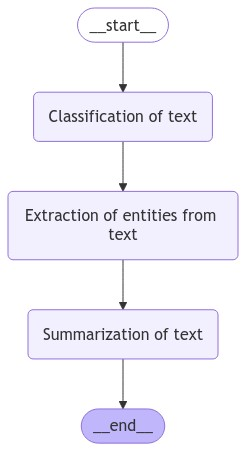

In [17]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
sample_text = "LangGraph, developed by LangChain Inc., is a tool designed to build workflows and decision trees using a graph-based structure. It allows developers to implement cycles, branching logic, and conditional flows, making it easier to manage complex interactions. LangGraph supports persistence, allowing workflows to save their state for error recovery or human-in-the-loop intervention. While it integrates well with LangChain, it can also function independently. Additionally, it offers features like token streaming, which enables partial results to be streamed in real-time during workflow execution."

sample_input = {'text':sample_text}
result = graph.invoke(sample_input)
print("Classification :",result["classification"])
print("\nEntities :",result["entities"])
print("\nSummary:",result["summary"])



Classification : Other

Entities : ['LangChain Inc.', ' LangGraph']

Summary: LangGraph is a graph-based tool that simplifies building complex workflows and decision trees with features like persistence, token streaming, and integration with LangChain.
